In [2]:
import sys
sys.path.append("../")

<center> This notebook is a practical application of the methods regarding the implementation of longstaff schwartz methods. </center> 

In [3]:
import numpy as np
from typing import Callable
from tqdm import tqdm 
from scipy.stats import norm

from SDE.utils.random_generation import generate_n_gaussian, generate_n_gaussian_quasi, generate_n_gaussian_quasi_paths
from SDE.basket import Weighted_Basket
from SDE.bs import BS_Asset
import SDE.utils.montecarlo_utils as mc
from SDE.montecarlo import mcls_pricing

# <center> Path simulation </center>

In [4]:
################################################################
##################### BASKET DEFINITION ########################
################################################################

risk_free_rate = 0.05
T = 1
strike = 200
nb_assets = 3
nb_periods = 6
times_path = [i*T/nb_periods for i in range(nb_periods+1)]      # equal periods

# taking real life parameters found above
asset_AAPL = BS_Asset(169.300003,0.20,risk_free_rate)
asset_AMZN = BS_Asset(179,0.32,risk_free_rate)
asset_TSLA = BS_Asset(179.99,0.53,risk_free_rate)
correl_matrix = [[1.000000, 0.884748, 0.827503], [0.884748, 1.000000, 0.793269], [0.827503, 0.793269, 1.000000]]

adjusted_weights = [2*0.196889,2*0.18622,2*0.185195]
my_basket_object = Weighted_Basket(adjusted_weights,[asset_AAPL,asset_AMZN,asset_TSLA],correl_matrix)

# building estimating function 
payoff = lambda basket_value : np.exp(-risk_free_rate*T)*max(basket_value-strike,0)
h = my_basket_object.h(T,payoff)

### Pseudo-random

In [6]:
### ASSET SIMULATION ###
one_brownian_vec = [generate_n_gaussian(1) for _ in times_path]

asset_value_path = asset_AAPL.simulate_path_with_brownian(times_path, one_brownian_vec)
print([f"T:{round(t,2)} -> S:{round(b,2)}" for t, b in zip(times_path, asset_value_path)])

### BASKET SIMULATION ###
T = 1
times_path = [i * T / nb_periods for i in range(nb_periods + 1)]
two_brownians_vec = [generate_n_gaussian(nb_assets) for _ in times_path]

basket_value_path = my_basket_object.simulate_path_with_brownian(times_path, two_brownians_vec)
print([f"T:{round(t,2)} -> S:{round(b,2)}" for t, b in zip(times_path, basket_value_path)])

['T:0.0 -> S:169.3', 'T:0.17 -> S:173.25', 'T:0.33 -> S:184.03', 'T:0.5 -> S:189.29', 'T:0.67 -> S:212.85', 'T:0.83 -> S:206.46', 'T:1.0 -> S:209.47']
['T:0.0 -> S:200.0', 'T:0.17 -> S:193.88', 'T:0.33 -> S:131.69', 'T:0.5 -> S:110.24', 'T:0.67 -> S:102.8', 'T:0.83 -> S:96.43', 'T:1.0 -> S:81.75']


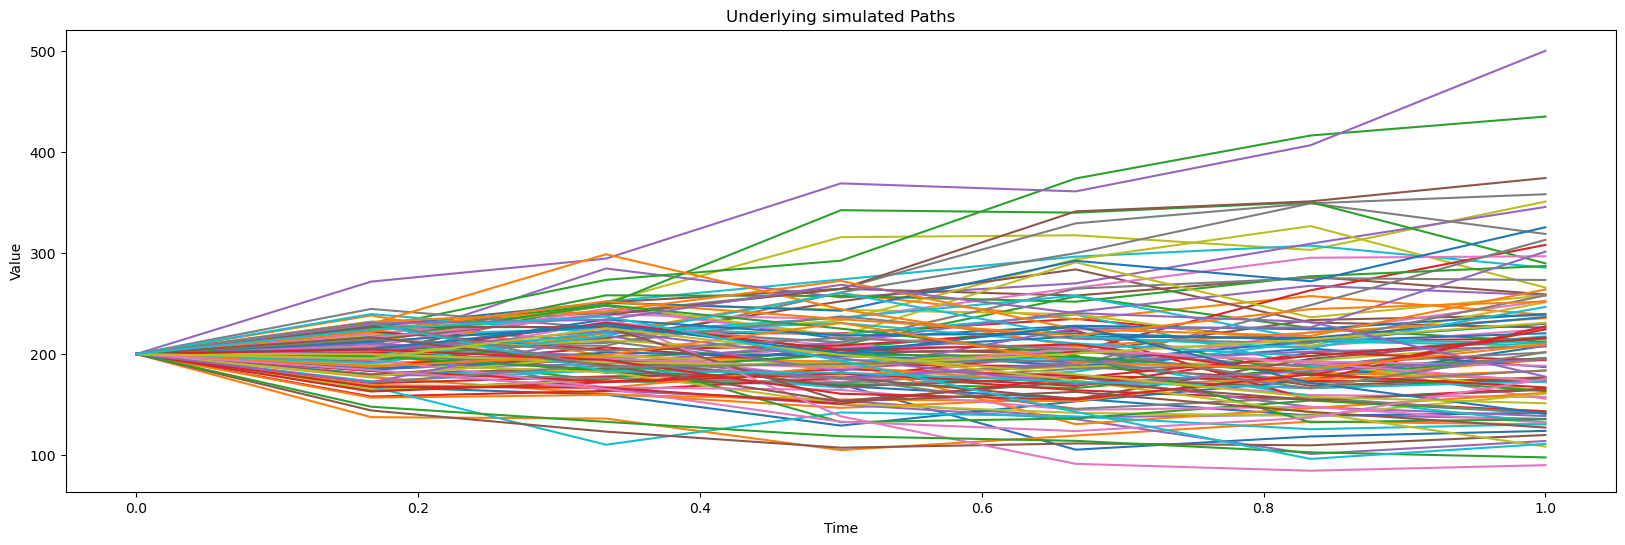

In [28]:
######################### PATH SIMULATIONS #########################
nb_simu_plot = 100

simulations_vec = [my_basket_object.simulate_path(times_path) for _ in range(nb_simu_plot)]

mc.plot_asset_paths(times_path, simulations_vec)

### Quasi-random

In [29]:
### ASSET SIMULATION ###
one_brownian_vec_quasi = [i[0] for i in generate_n_gaussian_quasi(1, len(times_path))]

asset_value_path_quasi = asset_AAPL.simulate_path_with_brownian(times_path, one_brownian_vec_quasi)
print([f"T:{round(t, 2)} -> S:{round(b, 2)}" for t, b in zip(times_path, asset_value_path_quasi)])

### BASKET SIMULATION ###
T = 1
times_path = [i * T / nb_periods for i in range(nb_periods + 1)]
two_brownians_vec_quasi = generate_n_gaussian_quasi(nb_assets, len(times_path))

basket_value_path_quasi = my_basket_object.simulate_path_with_brownian(times_path, two_brownians_vec_quasi)
print([f"T:{round(t,2)} -> S:{round(b,2)}" for t, b in zip(times_path, basket_value_path_quasi)])

['T:0.0 -> S:169.3', 'T:0.17 -> S:170.15', 'T:0.33 -> S:161.84', 'T:0.5 -> S:171.86', 'T:0.67 -> S:157.24', 'T:0.83 -> S:162.19', 'T:1.0 -> S:158.82']
['T:0.0 -> S:200.0', 'T:0.17 -> S:192.48', 'T:0.33 -> S:178.71', 'T:0.5 -> S:189.99', 'T:0.67 -> S:169.75', 'T:0.83 -> S:170.64', 'T:1.0 -> S:157.89']


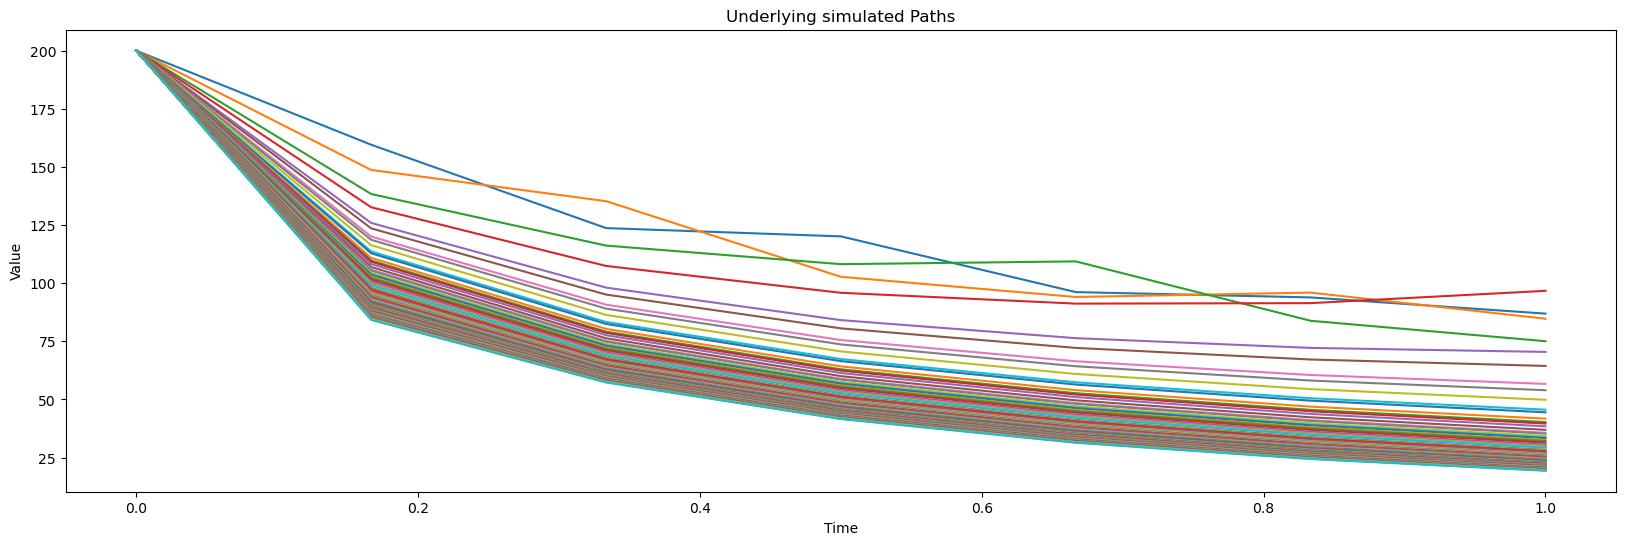

In [30]:
######################### PATH SIMULATIONS #########################
nb_simu_plot = 100
d_gaussian_path_vec_plot_quasi = generate_n_gaussian_quasi_paths(nb_assets, nb_simu_plot, len(times_path))

simulations_vec_quasi = [my_basket_object.simulate_path_with_brownian(times_path, brownians) for brownians in d_gaussian_path_vec_plot_quasi]

mc.plot_asset_paths(times_path, simulations_vec_quasi)

# <center> Longstaff schwartz computation </center>

## European price

In [31]:
mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= [0,1], 
             nb_simulations = 90000, 
             verbose=False)

29.92025954233542

## Simple estimator

****************************** MCLS path simulation ******************************
****************************** MCLS initialisation ******************************
**************************** MCLS backward iterating ****************************
**************************** Period 0.83: perform LS ****************************
********************* Period 0.83: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 53996.34it/s]


**************************** Period 0.67: perform LS ****************************
********************* Period 0.67: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 31528.96it/s]


***************************** Period 0.5: perform LS *****************************
********************** Period 0.5: compute optimal decision **********************


100%|██████████| 9000/9000 [00:00<00:00, 27081.61it/s]


**************************** Period 0.33: perform LS ****************************
********************* Period 0.33: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 25705.70it/s]


**************************** Period 0.17: perform LS ****************************
********************* Period 0.17: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 28383.38it/s]

*************************** LCLS giving result: 32.44 ***************************


32.44352869924149

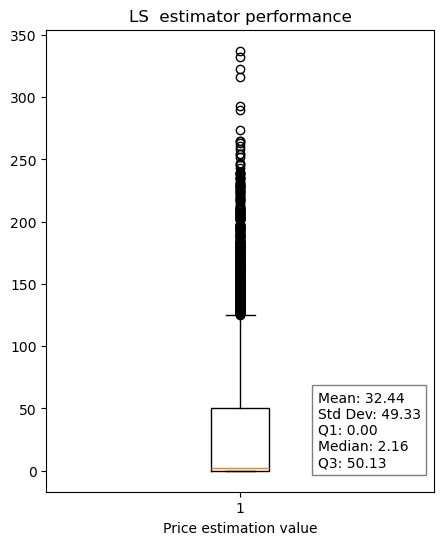

In [32]:
mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = 9000,
             verbose = True,
             display_performance= True)

## Antithetic estimator

In [33]:
mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = 9000,
             verbose = True,
             A_transformation = lambda x: -x,
             display_performance= True)

****************************** MCLS path simulation ******************************
****************************** MCLS initialisation ******************************
**************************** MCLS backward iterating ****************************
**************************** Period 0.83: perform LS ****************************
********************* Period 0.83: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 29566.27it/s]


**************************** Period 0.67: perform LS ****************************
********************* Period 0.67: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 27394.08it/s]


***************************** Period 0.5: perform LS *****************************
********************** Period 0.5: compute optimal decision **********************


100%|██████████| 9000/9000 [00:00<00:00, 28675.49it/s]


**************************** Period 0.33: perform LS ****************************
********************* Period 0.33: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 33259.33it/s]


**************************** Period 0.17: perform LS ****************************
********************* Period 0.17: compute optimal decision *********************


100%|██████████| 9000/9000 [00:00<00:00, 26894.97it/s]

******************************* Antithetic method *******************************


TypeError: bad operand type for unary -: 'list'

## Control variate estimator

In [ ]:
def m_function(basket_object:Basket,r,K,T):
    """
    computing E[h0(X)] for given basket and values
    """
    covar_matrix = basket_object.correl_matrix.m
    mu_star = np.array([alpha_i*a.vol*np.sqrt(T) for alpha_i,a in zip(basket_object.weights,basket_object.assets)])
    sigma_star = np.sqrt(np.dot(np.dot(mu_star.T,covar_matrix),mu_star))
    cst = np.exp(np.sum([alpha_i*(np.log(a.initial_spot)+(a.rf-a.vol**2/2)*T) for alpha_i,a in zip(basket_object.weights,basket_object.assets)]))   

    d1 = np.log(cst/K)/sigma_star + sigma_star
    d2 = d1 - sigma_star

    m = (cst*np.exp(0.5*sigma_star**2)*norm.cdf(d1) - K*norm.cdf(d2))*np.exp(-r*T)
    return m

def h0(brownian_path_vec,basket_object:Basket,times_path,payoff_function:Callable)-> Callable:
    """
    ** ATTENTION ** : payoff_function must be actualised if applying 

    payoff_function (func): payoff function computing the price for given underlying terminal values 
    Returns : 
        returns functions h0(((w1_0,...,w1_n),..,(wd_0,...,wd_n))) = payoff_function applied for log method for the given simulations to the basket

        >>> output : ((w1_0,...,w1_n),..,(wd_0,...,wd_n)) -> exp(sum(alpha_i*S_T_i)) = Mult(X_T((wi_0,...,wi_n))**alpha_i)
    """

    log_basket_terminal_value = basket_object.simulate_log_path(times_path,brownian_path_vec)[-1]

    return payoff_function(log_basket_terminal_value)

In [ ]:
####### building estimator function #######
m_value = m_function(my_basket_object,risk_free_rate,strike,times_path[-1])

mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = 90000,
             verbose = False,
             A_transformation = None, #lambda x: -x,
             h0_function= lambda brownian_path_vec : h0(brownian_path_vec,my_basket_object,times_path,lambda x : np.exp(-risk_free_rate*T)*max(x-strike,0)),
             m_value=m_value,
             display_performance= False)

## Control + Antithetic variate estimator

In [ ]:
####### building estimator function #######
m_value = m_function(my_basket_object,risk_free_rate,strike,times_path[-1])

mcls_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             nb_simulations = 90000,
             verbose = False,
             A_transformation = lambda x: -x,
             h0_function= lambda brownian_path_vec : h0(brownian_path_vec,my_basket_object,times_path,lambda x : np.exp(-risk_free_rate*T)*max(x-strike,0)),
             m_value=m_value,
             display_performance= False)

In [ ]:
def m_function_test(basket_object:Basket,r,K,T):
    """
    computing E[h0(X)] for given basket and values
    """
    covar_matrix = basket_object.correl_matrix.m
    mu_star = np.array([alpha_i*a.vol*np.sqrt(T) for alpha_i,a in zip(basket_object.weights,basket_object.assets)])
    sigma_star = np.sqrt(np.dot(np.dot(mu_star.T,covar_matrix),mu_star))
    cst = np.exp(np.sum([alpha_i*(np.log(a.initial_spot)+(a.rf-a.vol**2/2)*T) for alpha_i,a in zip(basket_object.weights,basket_object.assets)]))   

    d1 = np.log(cst/K)/sigma_star + sigma_star
    d2 = d1 - sigma_star

    m = (cst*np.exp(0.5*sigma_star**2)*norm.cdf(d1) - K*norm.cdf(d2))*np.exp(-r*T)
    return m

def h0_test(brownian_vec,basket_object:Basket,T,payoff_function:Callable)-> Callable:
    return payoff_function(basket_object.log_simulate(T,brownian_vec))

####### building estimator function #######
payoff = lambda basket_value : np.exp(-risk_free_rate*T)*max(basket_value-strike,0)

mc.mc_pricing(underlying= my_basket_object , 
             actualisation_rate= risk_free_rate, 
             terminal_payoff_function= lambda x : max(x-strike,0), 
             exercise_times= times_path, 
             maturity = T,
             nb_simulations = 90000,
             verbose = False,
             A_transformation = lambda x: -x,
             h0_function= lambda brownian_vec : h0_test(brownian_vec,my_basket_object,T,payoff),
             m_value=m_function_test(my_basket_object,risk_free_rate,strike,T),
             display_performance= False)